In [1]:
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt
import os

In [2]:
def plotGauss(vals,base,a,mean,sig):
    '''Plot gaussian distribution for vals with given parameters'''
    return base+a*np.exp(-((vals-mean)**2)/(2*sig**2))

In [3]:
from scipy import optimize
def gaussian(x, amplitude, mean, stddev):
    """Plot gaussian distribution for x with given parameters"""
    return amplitude * np.exp(-((x - mean) / np.sqrt(2) / stddev)**2)

def plotPrep(arr,binnum=50,ws=None):
    """Get arr ready for plotting, if QE then include weights in the histogramming
        return the counts for each hist bin and the x-value of the middle of the bins"""
    vals, edges = np.histogram(arr,bins=binnum,weights=ws)
    binwidth = (edges[1]-edges[0])/2
    midbin = edges[:-1]+binwidth
    
    return vals, midbin

def gaussianFit(midbin,vals):
    """Git a gaussian to the data given and return the dist at midbin values"""
    base = np.average(np.concatenate((vals[1:10],vals[-10:-1]))); adjvals = vals-base
    berr = np.std(np.concatenate((vals[1:10],vals[-10:-1])))/np.sqrt(len(np.concatenate((vals[1:10],vals[-10:-1]))))
    popt, pcov = optimize.curve_fit(gaussian, midbin, adjvals)
    gausvals = gaussian(midbin,*popt)+base
    argerr = np.sqrt(np.diag(pcov))/np.sqrt(sum(vals))
    print("Base %.4f ± %.4f\nAmplitude: %.4f ± %.4f\nMean: %.4f ± %.4f\nStd. Dev: %.4f ± %.4f" % (base,berr,popt[0],argerr[0],popt[1],argerr[1],popt[2],argerr[2]))
    return gausvals
def gaussianParams(midbin,vals):
    """Return only the parameters of the gaussian fit (along with error) and not the distribution itself"""
    base = np.average(np.concatenate((vals[1:10],vals[-10:-1]))); adjvals = vals-base
    berr = np.std(np.concatenate((vals[1:10],vals[-10:-1])))/np.sqrt(len(np.concatenate((vals[1:10],vals[-10:-1]))))
    popt, pcov = optimize.curve_fit(gaussian, midbin, adjvals)
    argerr = np.sqrt(np.diag(pcov))/np.sqrt(sum(vals))
   
    #print("Base %.4f ± %.4f\nAmplitude: %.4f ± %.4f\nMean: %.4f ± %.4f\nStd. Dev: %.4f ± %.4f" % (base,berr,popt[0],argerr[0],popt[1],argerr[1],popt[2],argerr[2]))
    return np.array([[base,berr],[popt[0],argerr[0]],[popt[1],argerr[1]],[popt[2],argerr[2]]])

In [4]:
def smear(data,width=3.5):
    """Smear the simulated data, default is 3.5ns although 7ns fits with STRAW data better we cannot yet
        justify the extra 3.5ns"""
    FWHM=width
    sig = FWHM/(2*np.sqrt(2*np.log(2)))
    rng = np.random.default_rng()
    rvals1 = rng.normal(loc=0,scale=sig,size=len(data))
    rvals2 = rng.normal(loc=0,scale=sig,size=len(data))
    
    return rvals1+rvals2+data

# New QE

In [5]:
coQE = np.loadtxt('Data/QE_coinc/all.txt',delimiter="\t")
coW = np.loadtxt('Data/QE_coinc/aweight.txt',delimiter="\t")
#coincidences from the QE_script notebook, data may be in mens' data directory
cmQE = smear(coQE.T[0],width=7)
dQE = np.around(cmQE,1)

In [6]:
#get yerr for hists
vals, edges = np.histogram(dQE,bins=np.arange(-24.5,25,1))
ypercent = np.sqrt(vals)/vals
ypercent

array([0.14142136, 0.16439899, 0.16222142, 0.14002801, 0.13608276,
       0.13363062, 0.12309149, 0.13363062, 0.12598816, 0.11704115,
       0.11867817, 0.12909944, 0.10783277, 0.10910895, 0.1132277 ,
       0.10976426, 0.09950372, 0.09325048, 0.07980869, 0.08304548,
       0.07624929, 0.07372098, 0.06608186, 0.06637233, 0.06085806,
       0.05986843, 0.06523281, 0.06726728, 0.06696495, 0.07955573,
       0.07980869, 0.08873565, 0.09090909, 0.11396058, 0.11043153,
       0.11470787, 0.12700013, 0.12216944, 0.12038585, 0.13363062,
       0.12803688, 0.12803688, 0.12598816, 0.12598816, 0.15075567,
       0.15430335, 0.13736056, 0.15617376, 0.18569534])

<IPython.core.display.Javascript object>


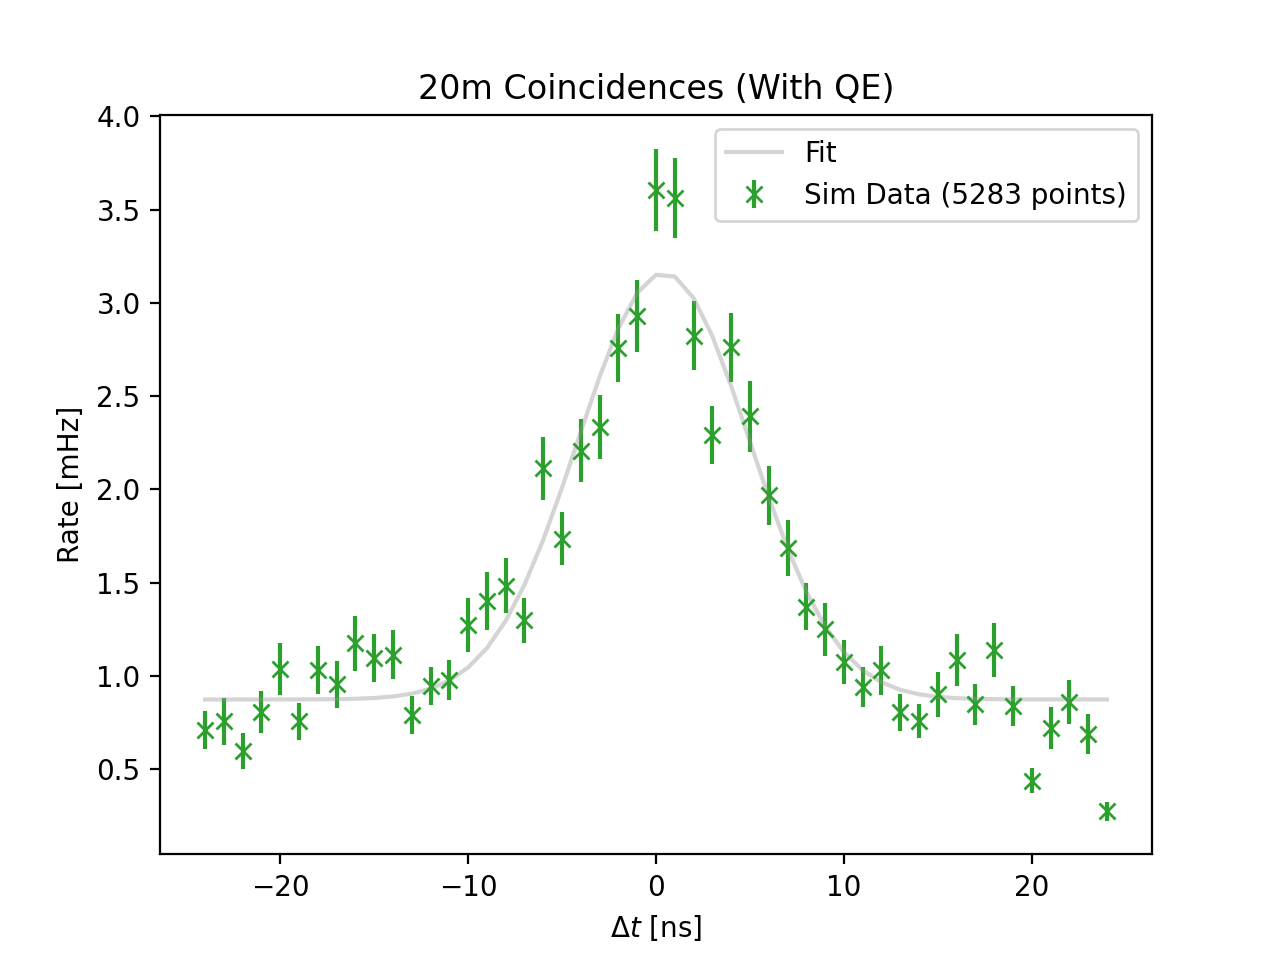

Base 0.8740 ± 0.0456
Amplitude: 2.2858 ± 0.0120
Mean: 0.4114 ± 0.0278
Std. Dev: 4.5740 ± 0.0278


In [8]:
#plot the coincidences along with a fit
tot_t = (800093+800001)/1e6 #had to read num lines from each nGen dir to get the time, this gives a rate on the y-axis
#instead of counts
bi = np.arange(-24.5,25,1) 
QE_bool = True #choose to plot QE or not
if QE_bool:
    plotQE = plotPrep(dQE,binnum=bi,ws=coW)
    pcolor = "C2"
    title_tag = "(With QE)"
else:
    plotQE = plotPrep(dQE,binnum=bi)
    pcolor = "C3"
    title_tag = "(No QE)"
plt.close() #acutally plot
plt.figure()
plt.plot(plotQE[1],gaussianFit(plotQE[1],plotQE[0]/tot_t),label=r"Fit", color="xkcd:grey",alpha=0.4)
plt.errorbar(plotQE[1],plotQE[0]/tot_t,yerr=ypercent*(plotQE[0]/tot_t),fmt='x', label="Sim Data ("+str(len(dQE))+" points)",color=pcolor)
plt.title("20m Coincidences "+title_tag)
plt.legend(loc=0)
plt.xlabel(r'$\Delta t$ [ns]')
plt.ylabel("Rate [mHz]")
plt.show()

<IPython.core.display.Javascript object>


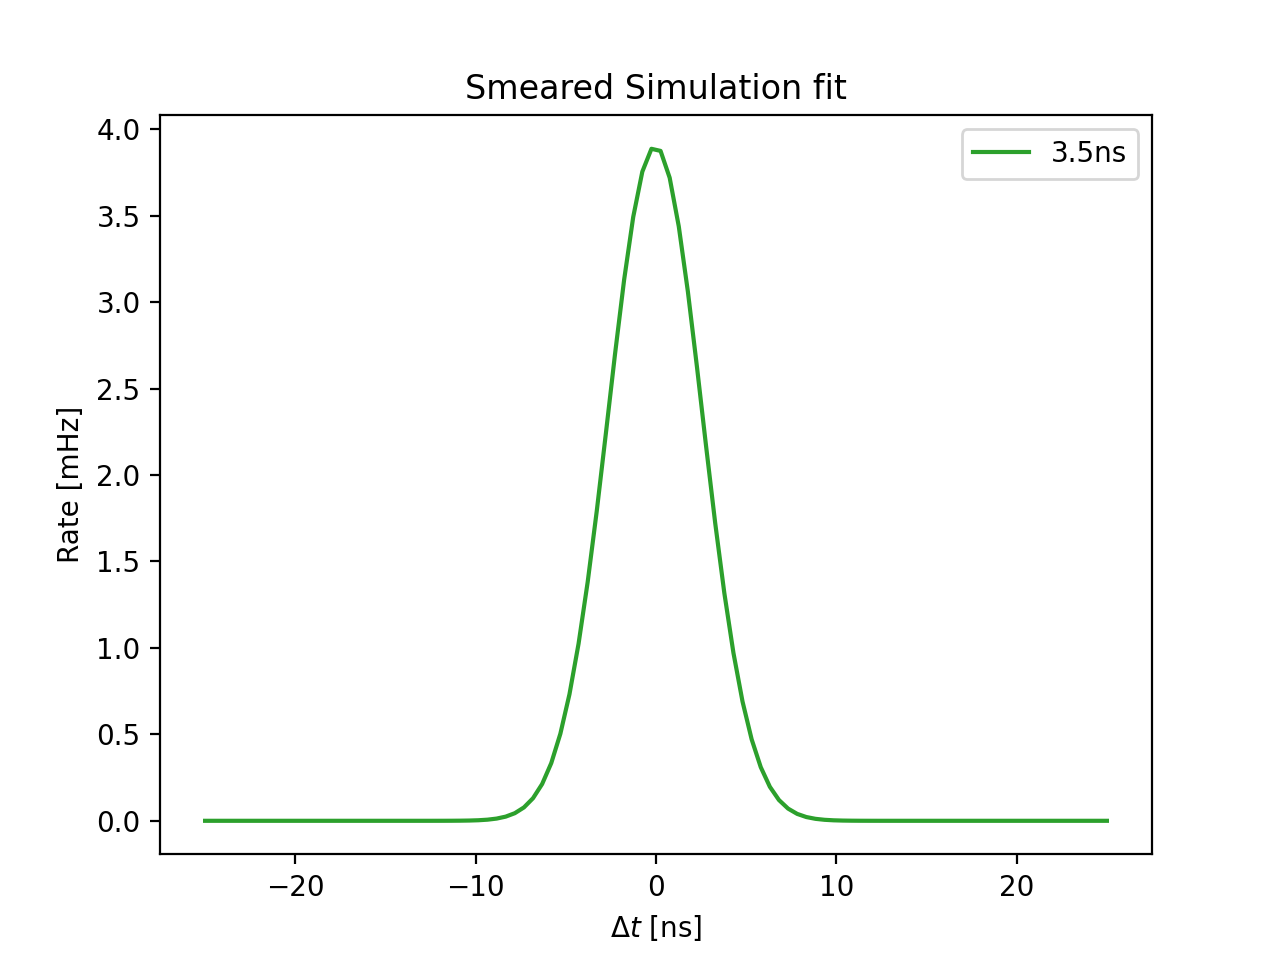

In [9]:
#just plot the gaussian for powerpoint comparision of peaks
coincpar = gaussianParams(plotQE[1],plotQE[0]/tot_t)
vals = np.linspace(-25,25,100)
plt.close()
plt.plot(vals,gaussian(vals,np.ones(len(vals))*3.9,np.ones(len(vals))*-0.042,np.ones(len(vals))*2.6),label="3.5ns",color="C2")
plt.title("Smeared Simulation fit")
plt.xlabel(r'$\Delta t$ [ns]')
plt.ylabel("Rate [mHz]")
plt.legend(loc=0)
plt.show()
